Import libraries

In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

Retrieve data from the server

In [2]:
# see the available projects
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [3]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test']


In [4]:
# optionally, remove some animals
animals_to_remove = ['test']
animals = [animal for animal in animals if animal not in animals_to_remove]
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']


In [5]:
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

receiving incremental file list
ACV001.csv

sent 18,997 bytes  received 254,546 bytes  109,417.20 bytes/sec
total size is 11,173,622  speedup is 40.85
receiving incremental file list
ACV002.csv

sent 17,653 bytes  received 294,352 bytes  124,802.00 bytes/sec
total size is 10,090,278  speedup is 32.34
receiving incremental file list
ACV003.csv

sent 20,239 bytes  received 306,585 bytes  130,729.60 bytes/sec
total size is 12,805,762  speedup is 39.18
receiving incremental file list
ACV004.csv

sent 14,965 bytes  received 184,513 bytes  79,791.20 bytes/sec
total size is 7,069,654  speedup is 35.44
receiving incremental file list
ACV005.csv

sent 17,749 bytes  received 204,188 bytes  88,774.80 bytes/sec
total size is 9,699,993  speedup is 43.71
receiving incremental file list
ACV006.csv

sent 20,683 bytes  received 350,284 bytes  148,386.80 bytes/sec
total size is 13,580,221  speedup is 36.61
receiving incremental file list
ACV007.csv

sent 19,123 bytes  received 237,595 bytes  171,145.33 

Read the data

In [6]:
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)

Loaded data for ACV001.
Loaded data for ACV002.
Loaded data for ACV003.
Loaded data for ACV004.
Loaded data for ACV005.
Loaded data for ACV006.
Loaded data for ACV007.
Loaded data for ACV008.


/tmp/ipykernel_275838/287582578.py:4: DtypeWarning: Columns (13,14,25,26,27,28,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV009.
Loaded data for ACV010.


In [7]:
# # create a profile report
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# # save the report to a file
# output_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("reports") / Path("profiling_report.html")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# profile.to_file(output_file=str(output_path))
# # print the path to the report
# print(f"Profiling report saved to {output_path}.")

Fill missing values and add some columns

In [8]:
df = dft.analyze_df(df)

Occupancy of the box and mouse entries analysis

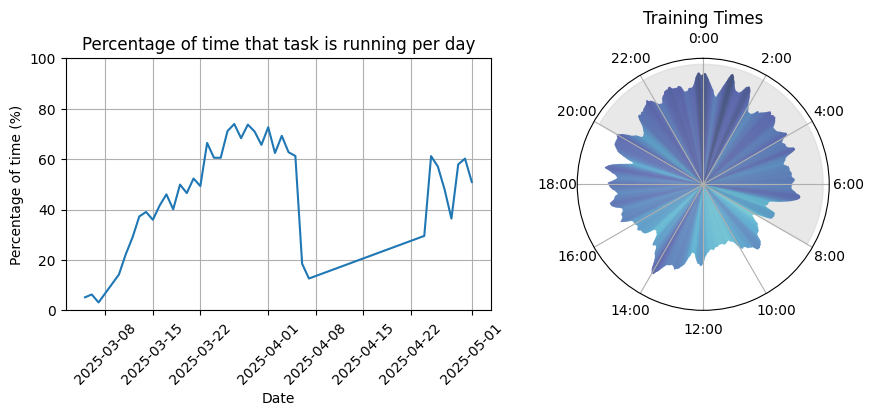

In [9]:
# Plot the percentage of time that the task is running per day and the heatmap of the occupancy during the day
occupancy_df = dft.get_start_and_end_of_sessions_df(df)
daily_percentages = dft.get_daily_occupancy_percentages(occupancy_df)
occupancy_heatmap = dft.get_occupancy_heatmap(occupancy_df, window_size=30)
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [3, 2]})
# plot the percentage of occupancy per day
plots.plot_percentage_of_occupancy_per_day(daily_percentages, ax=axs[0])
# plot the heatmap of occupancy
# transform the second plot to a polar one like this subplot_kw={'projection': 'polar'}
fig.delaxes(axs[1])  # Remove the default second subplot
axs[1] = fig.add_subplot(1, 2, 2, projection='polar')  # Add a polar subplot
plots.plot_training_times_clock_heatmap(occupancy_heatmap, ax=axs[1])
plt.tight_layout()
plt.show()


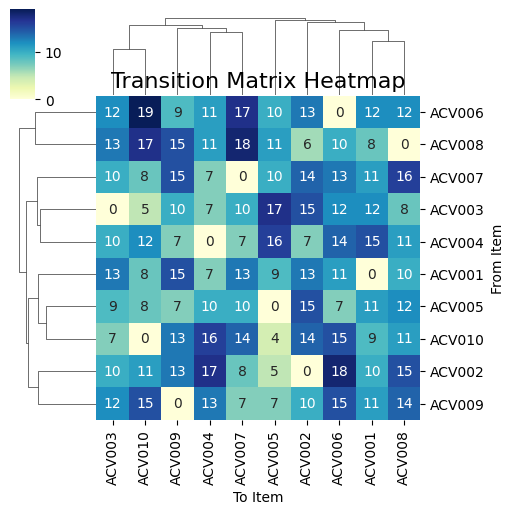

In [10]:
## Analyse the entry orders of the animals
# Sort the dataframe by start_time
sorted_occupancy_df = occupancy_df.sort_values(by='start_time')
# Extract the ordered list of subject names
ordered_subjects = sorted_occupancy_df['subject'].tolist()
# Create the transition matrix
transition_matrix = dft.create_transition_matrix(ordered_subjects)
# Plot the transition matrix
# fig, ax = plt.subplots(figsize=(8, 6))
plots.plot_transition_matrix(transition_matrix)
plt.show()

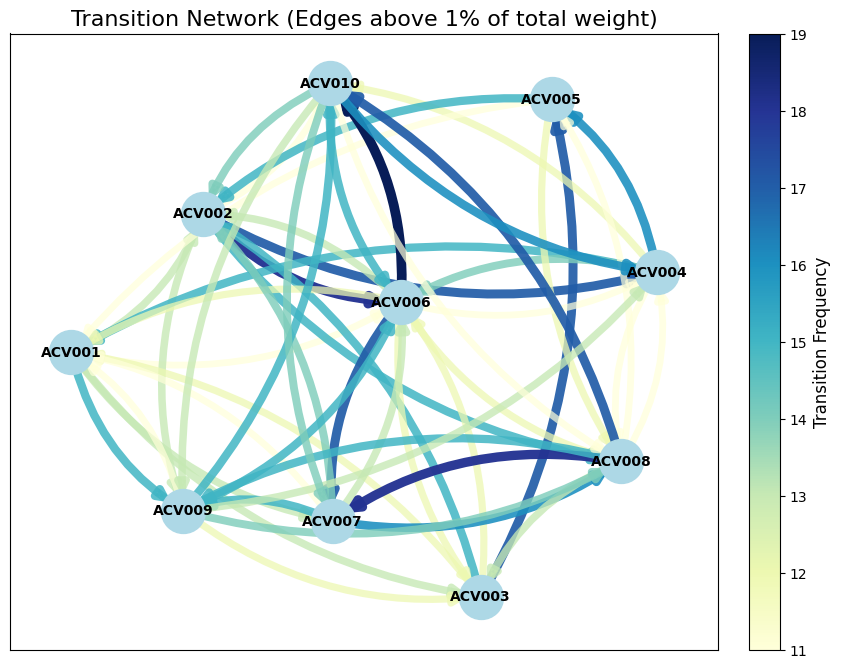

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_transition_network_with_curved_edges(transition_matrix, threshold=0):
    # Create a directed graph from the transition matrix
    G = nx.from_pandas_adjacency(transition_matrix, create_using=nx.DiGraph)
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency
    
    # Calculate total edge weight and filter edges above the threshold
    total_weight = sum(G[u][v]['weight'] for u, v in G.edges())
    min_weight = threshold * total_weight / 100  # Calculate the minimum weight based on % threshold
    
    plt.figure(figsize=(10, 8))
    
    # Edge attributes: Filter edges above the threshold and scale them
    filtered_edges = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= min_weight]
    edge_weights = [G[u][v]['weight'] for u, v in filtered_edges]
    
    # Normalize edge properties for filtered edges
    if edge_weights:
        max_weight = max(edge_weights)
    else:
        max_weight = 1  # Prevent division by zero if no edges remain
    
    edge_widths = [2 + (5 * G[u][v]['weight'] / max_weight) for u, v in filtered_edges]
    edge_alphas = [0.3 + (0.7 * G[u][v]['weight'] / max_weight) for u, v in filtered_edges]
    
    # Apply a colormap to the edges based on normalized weights
    norm = mcolors.Normalize(vmin=min(edge_weights, default=0), vmax=max_weight)
    edge_colors = [cm.YlGnBu(norm(G[u][v]['weight'])) for u, v in filtered_edges]
    
    # Draw larger, fully opaque nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', alpha=1.0)
    
    # Draw curved edges with varying properties, terminating early at the nodes
    for i, (u, v) in enumerate(filtered_edges):
        # Curve edges if they're bidirectional
        if G.has_edge(v, u) and (u, v) != (v, u):
            curve_scale = 0.2  # Add curvature for bidirectional edges
        else:
            curve_scale = 0
        
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=edge_widths[i], alpha=edge_alphas[i], edge_color=[edge_colors[i]],
            connectionstyle=f"arc3,rad={curve_scale}", arrows=True, arrowsize=15, arrowstyle='-|>',
            min_source_margin=10, min_target_margin=10,  # Terminate arrows earlier at the node edges
        )
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Transition Frequency', fontsize=12)

    plt.title(f'Transition Network (Edges above {threshold}% of total weight)', fontsize=16)
    plt.show()

# Example Usage:
# Show edges with weight greater than 10% of the total edge weight
plot_transition_network_with_curved_edges(transition_matrix, threshold=1)


Trials per day and evolution of performance

In [12]:
# plot the number of trials per day
df_to_plot = df.groupby(['subject', 'year_month_day', 'current_training_stage']).size().reset_index(name='trials')
# add also the correct percentage
df_to_plot_correct = df.groupby(['subject', 'year_month_day', 'current_training_stage'])[['correct', 'miss_trial']].mean().reset_index()
# merge the two dataframes
df_to_plot = df_to_plot.merge(df_to_plot_correct, on=['subject', 'year_month_day', 'current_training_stage'])
# sort the dataframe by date
df_to_plot = df_to_plot.sort_values(by=['year_month_day'])
# replace the current_training_stage values with more readable ones
df_to_plot['current_training_stage'] = df_to_plot['current_training_stage'].replace({
    'not saved': 'Habituation',
})

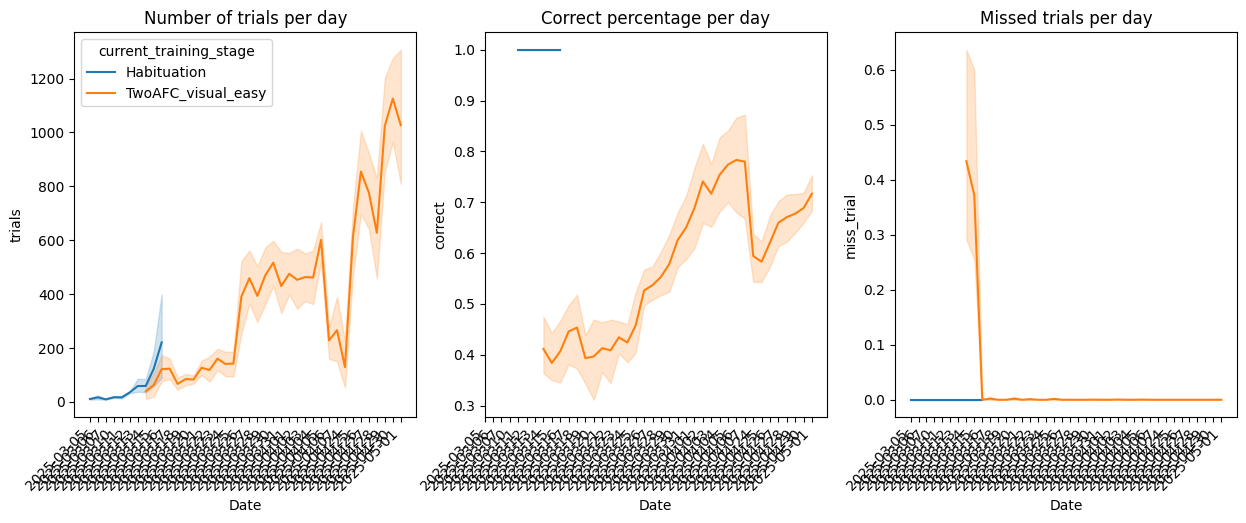

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
sns.lineplot(data=df_to_plot, x='year_month_day', y='trials', hue='current_training_stage', ax=axs[0])
axs[0].set_title('Number of trials per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='correct', hue='current_training_stage', ax=axs[1])
axs[1].set_title('Correct percentage per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='miss_trial', hue='current_training_stage', ax=axs[2])
axs[2].set_title('Missed trials per day')
for ax in axs:
    ax.set_xlabel('Date')
    # tilt the x-axis labels and align them to the right
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
# remove legends of 1 and 2
for ax in axs[1:]:
    ax.legend_.remove()


plt.show()

In [14]:
# plot what the animal is doing, if it is alternating or repeating to the left or to the right
# NOTE: This is not the same as the next analysis, as this is what the animal is doing, not what it should do
df = dft.add_port_where_animal_comes_from(df)

In [15]:
# get a metric to see the bias in choices (including alternation)
df['roa_choice_numeric'] = df.apply(utils.get_repeat_or_alternate_to_numeric, axis=1)

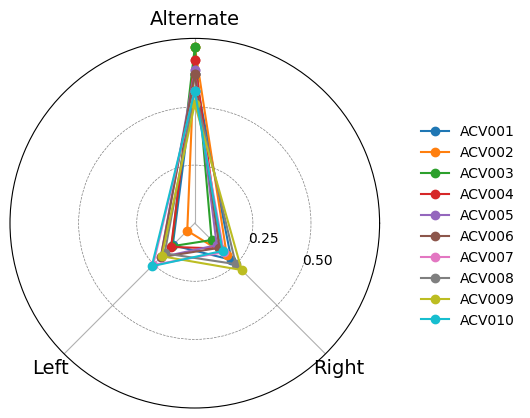

In [16]:
# create a polar plot to see the general bias
df_triangle_polar = dft.get_triangle_polar_plot_df(df)
# plot the polar plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax = plots.triangle_polar_plot(df_triangle_polar, ax=ax)
plt.show()

In [17]:
# show the triangles above per animal fluctuating per X number of trials with different hue
# df_animal_choices_evolution_df
trial_group_size = 500
df_anchev = df.copy()
df_anchev['trial_group'] = df_anchev['total_trial'] // trial_group_size * trial_group_size
df_anchev = df_anchev.groupby(['subject', 'trial_group'])['roa_choice_numeric'].value_counts().reset_index(name='count')
# transform counts into percentages
df_anchev['percentage'] = df_anchev['count'] / df_anchev.groupby(['subject', 'trial_group'])['count'].transform('sum')


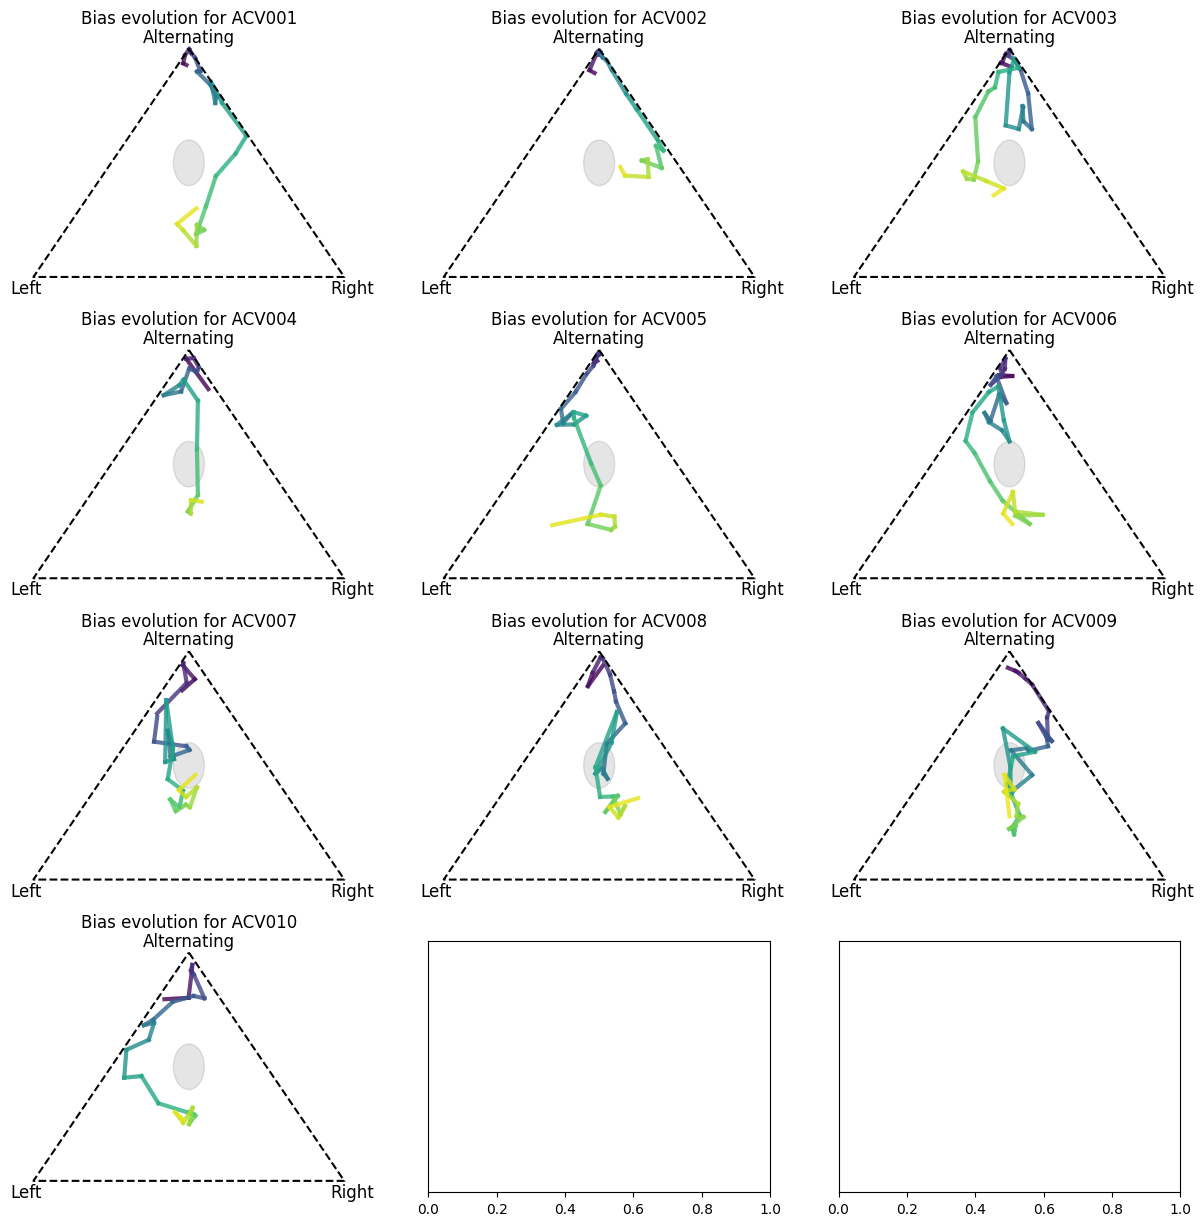

In [18]:

# plot the trajectory of the xs and ys through the sessions
# show this analysis for all the mice
total_subjects = df_anchev['subject'].nunique()
ncols = 4
nrows = int(np.ceil(total_subjects / ncols))
fig, axs = plt.subplots(ncols, nrows, figsize=(15, 5 * nrows), sharey=True)

for subject, ax in zip(df_anchev['subject'].unique(), axs.ravel()):

    subject_data = df_anchev[df_anchev['subject'] == subject]
    # pivot or melt the dataframe so that each subject and session has a y value, that will be the percentage when the bias
    # is 0, and the x value will be the differences between the percentages when the bias is 1 and -1
    df_bias_pivot = subject_data.pivot(index='trial_group', columns='roa_choice_numeric', values='percentage')

    # fill the NaN values with 0
    df_bias_pivot = df_bias_pivot.fillna(0)
    # calculate the difference between the percentages when the bias is 1 and -1
    df_bias_pivot['xs'] = df_bias_pivot[1] - df_bias_pivot[-1]
    df_bias_pivot['ys'] = df_bias_pivot[0]
    # reset index
    df_bias_pivot = df_bias_pivot.reset_index()

    # convert the xs and ys points to lines by duplicating the endpoint using the next trial group
    dfbps = df_bias_pivot.copy()
    dfbps['trial_group'] = dfbps['trial_group'].shift(1)
    # add the two dataframes together
    df_bias_pivot_merged = pd.concat([df_bias_pivot, dfbps], ignore_index=True)
    df_bias_pivot_merged.dropna(inplace=True)


    # plot the trajectory of the xs and ys through the sessions, without averaging the same values
    sns.lineplot(data=df_bias_pivot_merged, x='xs', y='ys', ax=ax,
                 hue='trial_group', palette='viridis', legend=False,
                 linewidth=3, alpha=0.8)
    # connect the points in the order of the session
    # plt.plot(df_bias_pivot['xs'], df_bias_pivot['ys'], marker='o', linestyle='-')

    # plot a triangle between -1 and 1 in the x axis and 0 and 1 in the y axis
    triangle = np.array([[0, 1], [1, 0], [-1, 0], [0, 1]])
    ax.plot(triangle[:, 0], triangle[:, 1], color='black', linestyle='--')
    # draw a dashed circle in 0, 0.5 of radius 0.1, no linestyle, fill it with black and alpha 0.1
    circle = plt.Circle((0, 0.5), 0.1, color='black', fill=True, alpha=0.1)
    ax.add_artist(circle)
    # label the triangle vertices
    ax.text(0, 1.05, 'Alternating', ha='center', va='center', fontsize=12)
    ax.text(1.05, -0.05, 'Right', ha='center', va='center', fontsize=12)
    ax.text(-1.05, -0.05, 'Left', ha='center', va='center', fontsize=12)
    # remove spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Bias evolution for {subject}', pad=10)

plt.show()


Analysis of the 2AFC task

In [19]:
# Correct percentage per total trial in 2AFC. Separate also alternating and repeating
df2afc = df[df['current_training_stage'] == 'TwoAFC_visual_easy']
# First, get a column that indicates what the animal should do
df_subject_list = []
for mouse in animals:
    df_mouse = df2afc[df2afc['subject'] == mouse]
    df_session_list = []
    for session in df_mouse['session'].unique():
        df_session = df_mouse[df_mouse['session'] == session].copy()
        df_session["repeat_or_alternate"] = dft.get_repeat_or_alternate_series(df_session.correct_side)
        df_session_list.append(df_session)
    # calculate the performances
    df_mouse = pd.concat(df_session_list, ignore_index=True)
    df_mouse = dft.get_repeat_or_alternate_performance(df_mouse, window=25)
    df_mouse = dft.get_performance_through_trials(df_mouse, window=25)
    df_subject_list.append(df_mouse)

df2afc = pd.concat(df_subject_list, ignore_index=True)

In [20]:
# Plot the performance through trials
# Bin the total trials every 100 trials
df2afc['total_trial_bin'] = df2afc['total_trial'] // 100 * 100
# Group by the binned total trials and calculate the mean performance
df_perf_binned = df2afc.groupby(['subject', 'total_trial_bin', 'repeat_or_alternate']).agg({'correct': 'mean'}).reset_index()

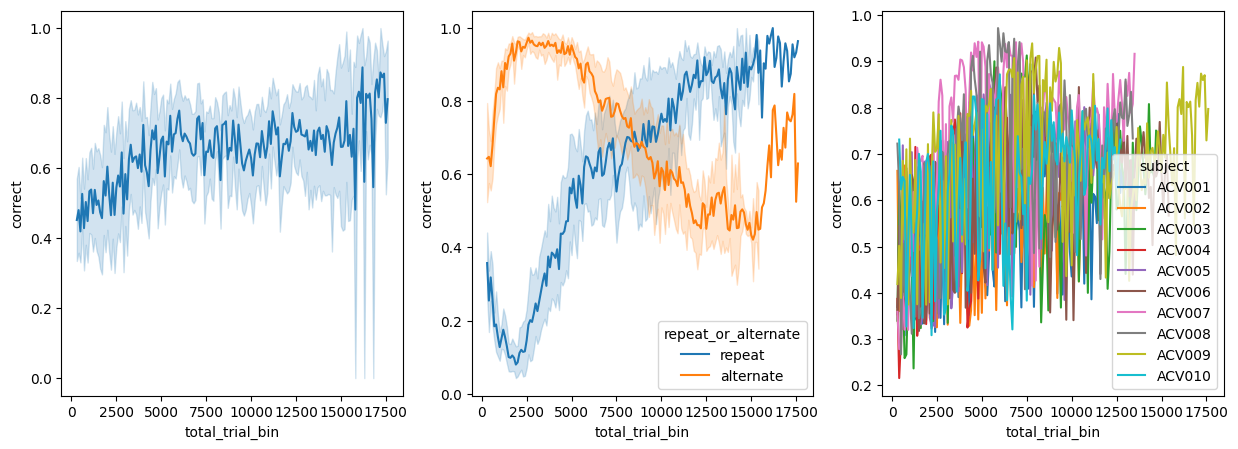

In [21]:
# plot the performance through trials
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
# plot the performance through trials
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', ax=axs[0])
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', hue='repeat_or_alternate', hue_order=['repeat', 'alternate'], ax=axs[1])
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', hue='subject', ax=axs[2], errorbar=None)
plt.show()

In [ ]:
#TODO: calculate reaction times per animal in 2AFC and show overlapping distributions
#TODO: show evolution of the reaction times per day, and the iti
#TODO: do this analysis for the postdoc data and compare

Look into behavior more closely

In [28]:
# select only one mouse for now
df2afc_sel = df2afc[df2afc['subject'] == 'ACV005']

In [29]:
# select those sessions with performance above 0.65
sessions_to_keep = df2afc_sel.groupby('session')['correct'].mean().reset_index()
sessions_to_keep = sessions_to_keep[sessions_to_keep['correct'] > 0.55]['session'].unique()
# filter the dataframe to keep only those sessions
df2afc_sel = df2afc_sel[df2afc_sel['session'].isin(sessions_to_keep)]

sessions_to_keep

array([15., 23., 25., 28., 29., 40., 47., 49., 50., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90.])

In [30]:
import ast
def add_visual_stimulus_difference(df):
    df['visual_stimulus'] = df['visual_stimulus'].apply(ast.literal_eval)
    df["visual_stim_difference"] = df["visual_stimulus"].apply(lambda x: x[0] - x[1])
    # bin the data every 0.1
    df["vis_stim_dif_bin"] = np.round((df["visual_stim_difference"] // 0.1) * 0.1, 1)
    return df

In [31]:
df2afc_sel = add_visual_stimulus_difference(df2afc_sel)

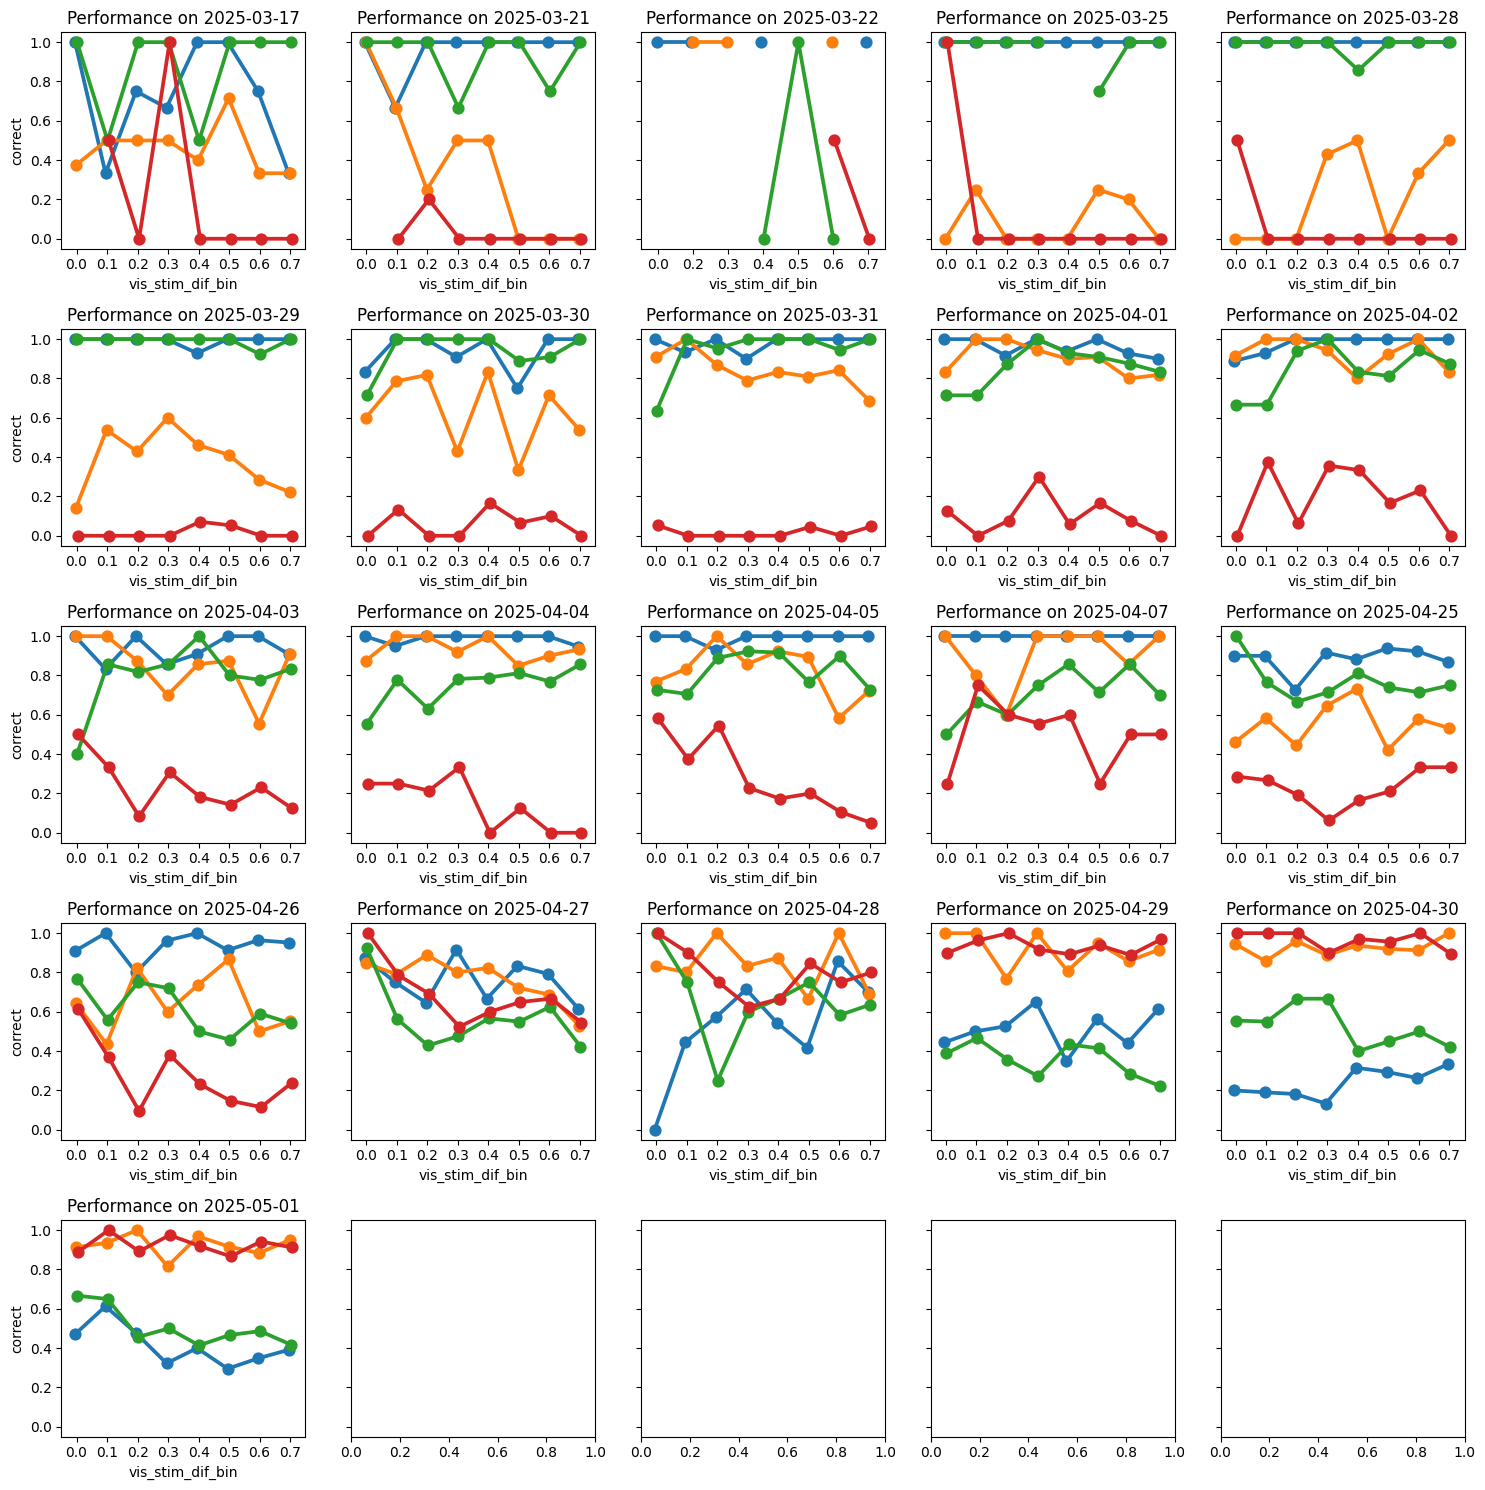

In [ ]:
# TODO: compare this with the condition of where the animal comes from

# check the evolution of each of these "decisions" during training
# group by the binned data and calculate the mean performance
df2afc_binned = df2afc_sel.groupby(['vis_stim_dif_bin', 'correct_side', 'repeat_or_alternate', 'year_month_day'])[['correct']].mean().reset_index()
# get the different combinations of correct side and repeat or alternate
df2afc_binned['correct_side_repeat_or_alternate'] = df2afc_binned['correct_side'] + '_' + df2afc_binned['repeat_or_alternate']
# get only the 4 combinations and remove nans etc
df2afc_binned = df2afc_binned[df2afc_binned['correct_side_repeat_or_alternate'].isin(['left_repeat', 'left_alternate', 'right_repeat', 'right_alternate'])]


# plot the binned data with the new combination for each day
fig, axs = plt.subplots(ncols=5, nrows=pd.unique(df2afc_binned['year_month_day']).size // 5 + 1, figsize=(15, 15), sharey=True)
axs = axs.ravel()
# plot the binned data for each day
for (day, group), ax in zip(df2afc_binned.groupby('year_month_day'), axs):
    try:
        sns.pointplot(data=group, x='vis_stim_dif_bin', y='correct', hue='correct_side_repeat_or_alternate', dodge=True, errorbar=None, ax=ax, legend=False)
    except ZeroDivisionError:
        # If there's a ValueError, it might be due to not enough data points for the hue
        # In this case, we can skip plotting for this group
        print(f"Skipping {day} due to insufficient data for plotting.")
        continue
    ax.set_title(f'Performance on {day}')
plt.tight_layout()
plt.show()

this shows that when they are learning and they struggle with a decision kind, they use the overall intensity of the port to take that decision. But it is not a general side bias, as it does not affect the alternation behavior

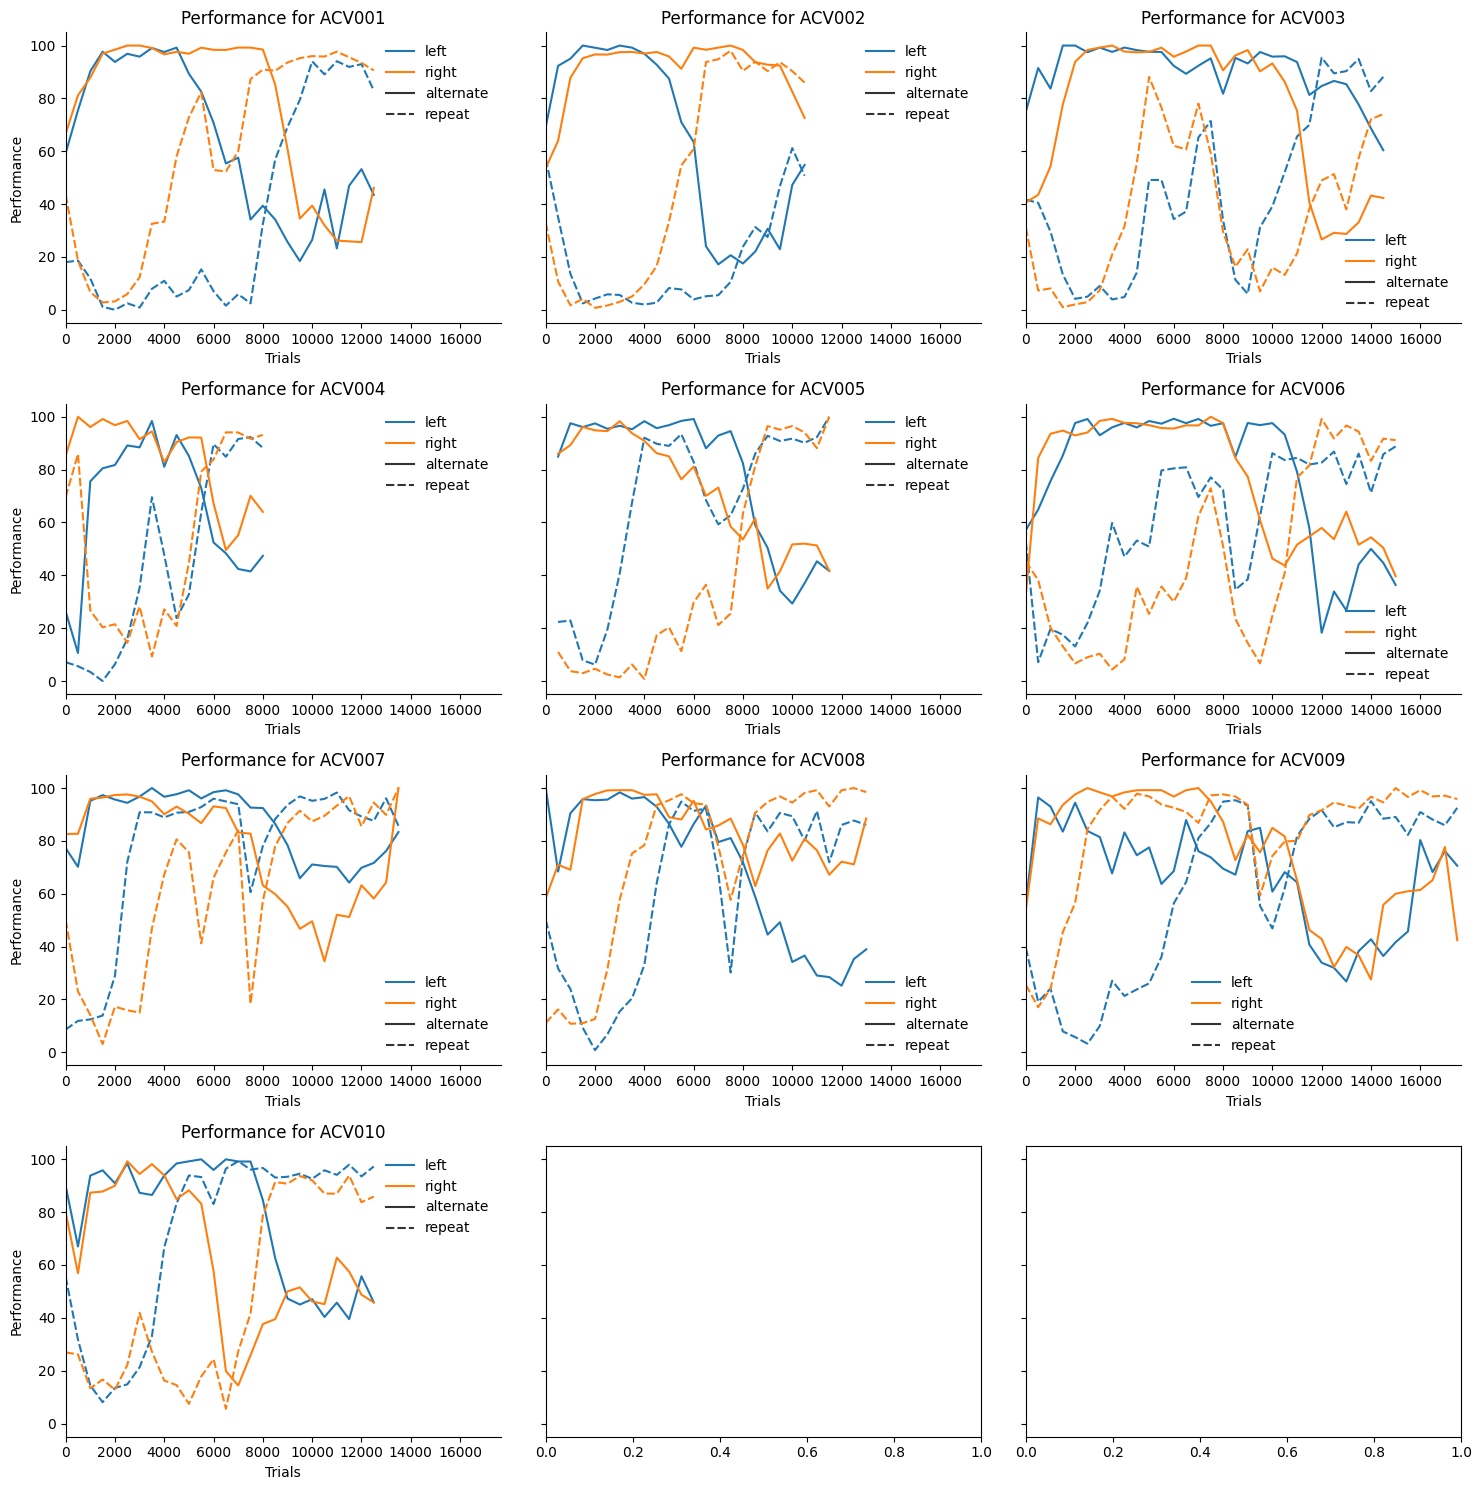

In [27]:
# show this analysis for all the mice
total_subjects = df2afc['subject'].nunique()
ncols = 4
nrows = int(np.ceil(total_subjects / ncols))
# find the max trials that a subject has done
max_trials = df2afc['total_trial'].max()
fig, axs = plt.subplots(ncols, nrows, figsize=(15, 5 * nrows), sharey=True)
for subject, ax in zip(df2afc['subject'].unique(), axs.ravel()):
    # filter the dataframe to keep only the current subject
    df_subject = df2afc[df2afc['subject'] == subject]
        # group by the binned data and calculate the mean performance
    df_pbd = dft.get_performance_by_decision_df(df_subject)
    # plot the data
    plots.performance_by_decision_plot(df_pbd, ax=ax)
    ax.set_title(f'Performance for {subject}')
    ax.set_xlim(0, max_trials)

plt.tight_layout()
plt.show()

each mouse has a prefered side, but they all have to counteract the "alternation" strategy, although they do this without affecting the performance on the alternation

In [ ]:

import altair as alt
import pandas as pd

# Sample data (replace with your actual dataset)
data = df_to_plot.copy()
# convert nans to 1
data['correct'] = data['correct'].fillna(1) * 100

In [ ]:
import altair as alt
import pandas as pd
import numpy as np

# Convert date to datetime format
data['year_month_day'] = pd.to_datetime(data['year_month_day'])

# Get min and max dates
min_date = data['year_month_day'].min()
max_date = data['year_month_day'].max()

# Create a list of all dates in the range
date_range = pd.date_range(start=min_date, end=max_date)
date_strings = [d.strftime('%Y-%m-%d') for d in date_range]

# Add a numeric field for the slider
data['date_index'] = data['year_month_day'].apply(
    lambda x: np.where(date_range == x)[0][0]
)

# Find global min and max values for x and y axes
min_trials = data['trials'].min()
max_trials = data['trials'].max()
min_correct = data['correct'].min()
max_correct = data['correct'].max()

# Add some padding to the axis limits (10%)
trials_padding = (max_trials - min_trials) * 0.1
correct_padding = (max_correct - min_correct) * 0.1

# Create a slider for date selection
date_slider = alt.binding_range(
    min=0,
    max=len(date_range)-1,
    step=1,
    name='Date: '
)

# Create a parameter that updates with the slider
date_selection = alt.param(
    name='date_idx',
    value=0,
    bind=date_slider
)

# Create a derived field for display purposes
slider_date = alt.expr.time(date_range[0].timestamp()*1000) + alt.expr.milliseconds(86400000 * date_selection)

# Hover selection for subjects
hover_selection = alt.selection_point(
    name='hover',
    on='mouseover', 
    fields=['subject'],
    empty=False
)

# Base chart encoding
base_encoding = dict(
    x=alt.X('trials:Q', 
            title='Number of Trials',
            scale=alt.Scale(domain=[min_trials - trials_padding, max_trials + trials_padding])),
    y=alt.Y('correct:Q', 
            title='Correct Choices (%)', 
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('current_training_stage:N', 
                    title='Training Stage',
                    legend=alt.Legend(orient='bottom', 
                                      titleFontSize=12, 
                                      labelFontSize=10))
)

# Main points filtered by current date
points = alt.Chart(data).mark_circle().encode(
    **base_encoding,
    size=alt.Size('trials:Q', title='Trials', scale=alt.Scale(range=[10, 200])),
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0.5)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    alt.datum.date_index == date_selection
).add_params(hover_selection)

# Trajectories that appear on hover
trajectories = alt.Chart(data).mark_line(
    opacity=0.7,
    strokeWidth=2
).encode(
    **base_encoding,
    detail='subject:N',
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0))
).transform_filter(
    hover_selection
)

# All points for the selected subject (trajectory points)
trajectory_points = alt.Chart(data).mark_circle(
    size=80
).encode(
    **base_encoding,
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    hover_selection
)

# Date labels for trajectory points
date_labels = alt.Chart(data).mark_text(
    align='left',
    baseline='middle',
    dx=10,
    fontSize=10
).encode(
    **base_encoding,
    text='year_month_day:T',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    hover_selection
)

# Subject labels that appear on hover
subject_labels = alt.Chart(data).mark_text(
    align='center',
    baseline='bottom',
    dy=-10,
    fontSize=14,
    fontWeight='bold'
).encode(
    **base_encoding,
    text='subject:N',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    alt.datum.date_index == date_selection
).transform_filter(
    hover_selection
)

# Current date display
date_display = alt.Chart({'values': [{}]}).mark_text(
    align='right',
    baseline='top',
    fontSize=14,
    font='Arial',
    fontWeight='bold',
    dx=-10,
    dy=10
).encode(
    text=alt.Text(
        'yearmonthdate(datum.date):T',
        title='Current Date'
    ),
    x=alt.value(600),  # Right side of the chart
    y=alt.value(0)     # Top of the chart
).transform_calculate(
    date=slider_date
)

# Combine all layers
chart = alt.layer(
    points, 
    trajectories, 
    trajectory_points, 
    date_labels, 
    subject_labels, 
    date_display
).properties(
    width=600, 
    height=400,
    title='Subject Performance by Date'
).add_params(date_selection)

chart

In [ ]:
data['year_month_day']

In [ ]:
plt.hist(df.TRIAL_END - df.TRIAL_START, bins=500)
plt.show()

In [ ]:
df.columns